## Importing the necessary libraries

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from _pickle import load, dump
import matplotlib.pyplot as plt
from sklearn import metrics
from dask import dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

## Importing the dataset

In [3]:
DATASET_PATH = '../Datasets/Accelerometer Data + TAC/'
datasets = {filename.split('.')[0]: dd.read_csv(f'{DATASET_PATH}feature_data_new/{filename}') for filename in os.listdir(f'{DATASET_PATH}feature_data_new/')}

In [3]:
total_len = 0
for dataset in datasets.values():
    total_len += len(dataset)
print(f'Total number of samples: {total_len}')

Total number of samples: 514306


In [4]:
X_data, y_data = [], []

for dataset in datasets.values():
    dataset = dataset.compute()
    X_data.extend(dataset.iloc[:, :-1].values)
    y_data.extend(dataset.iloc[:, -1].values)

X_data = np.array(X_data)
y_data = np.array(y_data)

Text(0.5, 1.0, 'Class distribution')

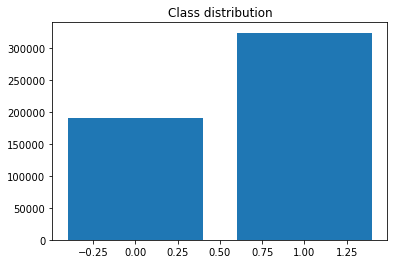

In [15]:
unique, counts = np.unique(y_data, return_counts=True)
plt.bar(unique, counts)
plt.title('Class distribution')

## Feature Scaling and Normalization

Splitting the dataset into the Training set and Test set

In [6]:
# TODO: #7 In feature extraction, label each row with the window number and the pid
# -> This will help compare the predictions by plotting over the real signal
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [7]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (411444, 864)
X_test shape: (72003, 864)
X_val shape: (30859, 864)


## Principal Component Analysis

In [9]:
pca = PCA(n_components=800)
pca.fit(X_train)

PCA(n_components=800)

Text(0, 0.5, 'Cumulative explained variance')

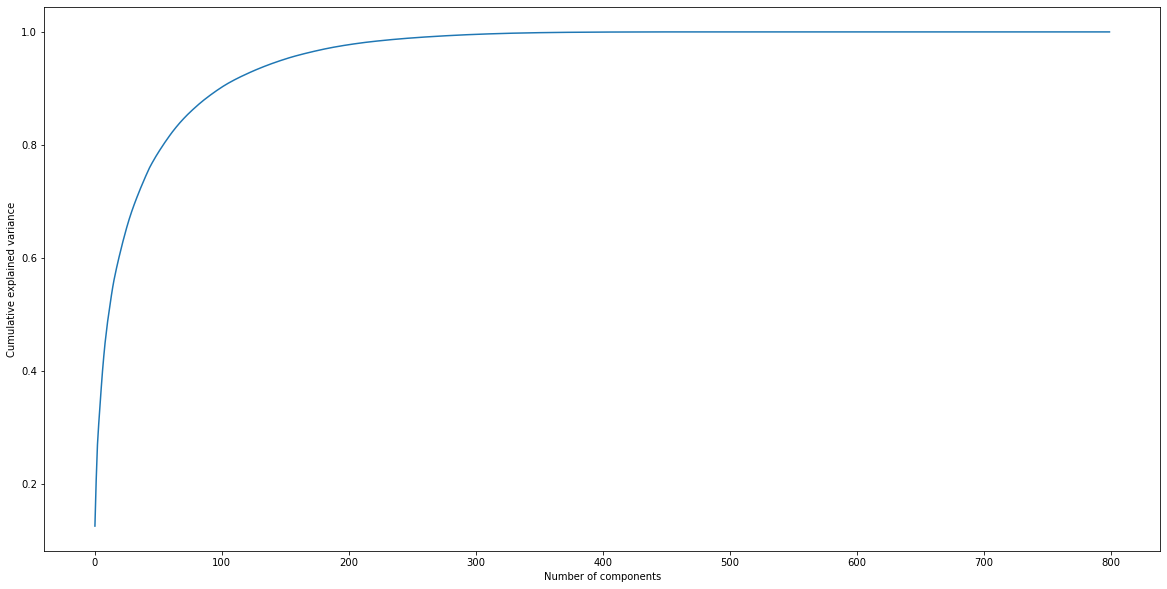

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

From the above plot, it can be seen that the explained cumulative variance is very high near 80 number of components and then increases very slowly. Thus, the data describing changes is mostly contained in 80 features.

In [10]:
n_features = 80

pca = PCA(n_components=n_features)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(X_test)

In [12]:
with open(f'{DATASET_PATH}train_data.pkl', 'wb') as f:
    dump([X_train_reduced, y_train], f)

with open(f'{DATASET_PATH}val_data.pkl', 'wb') as f:
    dump([X_val_reduced, y_val], f)

with open(f'{DATASET_PATH}test_data.pkl', 'wb') as f:
    dump([X_test_reduced, y_test], f)

In [14]:
with open(f'{DATASET_PATH}train_data.pkl', 'rb') as f:
    X_train_reduced, y_train = load(f)

with open(f'{DATASET_PATH}val_data.pkl', 'rb') as f:
    X_val_reduced, y_val = load(f)

with open(f'{DATASET_PATH}test_data.pkl', 'rb') as f:
    X_test_reduced, y_test = load(f)

In [15]:
print(f'X_train_reduced shape: {X_train_reduced.shape}')
print(f'X_test_reduced shape: {X_test_reduced.shape}')
print(f'X_val_reduced shape: {X_val_reduced.shape}')

X_train_reduced shape: (411444, 80)
X_test_reduced shape: (72003, 80)
X_val_reduced shape: (30859, 80)


## Model Training

### Deep ANN

In [16]:
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_reduced.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 60
learning_rate = 0.1
decay_rate = 0.01
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate)

exp_decay = lambda epoch: learning_rate * np.exp(-decay_rate * epoch)
lr_schedule = LearningRateScheduler(exp_decay)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

nn_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
history = nn_model.fit(X_train_reduced, y_train, epochs=epochs, validation_data=(X_val_reduced, y_val), callbacks=[lr_schedule, early_stop], batch_size=128)

Epoch 1/60
3215/3215 [==============================] - 24s 5ms/step - loss: 0.3919 - accuracy: 0.8331 - val_loss: 0.3782 - val_accuracy: 0.8393
Epoch 2/60
3215/3215 [==============================] - 15s 5ms/step - loss: 0.3729 - accuracy: 0.8433 - val_loss: 0.3711 - val_accuracy: 0.8430
Epoch 3/60
3215/3215 [==============================] - 15s 5ms/step - loss: 0.3674 - accuracy: 0.8460 - val_loss: 0.3658 - val_accuracy: 0.8467
Epoch 4/60
3215/3215 [==============================] - 17s 5ms/step - loss: 0.3639 - accuracy: 0.8476 - val_loss: 0.3630 - val_accuracy: 0.8487
Epoch 5/60
3215/3215 [==============================] - 18s 5ms/step - loss: 0.3615 - accuracy: 0.8490 - val_loss: 0.3609 - val_accuracy: 0.8496
Epoch 6/60
3215/3215 [==============================] - 17s 5ms/step - loss: 0.3596 - accuracy: 0.8497 - val_loss: 0.3593 - val_accuracy: 0.8507
Epoch 7/60
3215/3215 [==============================] - 18s 6ms/step - loss: 0.3581 - accuracy: 0.8503 - val_loss: 0.3579 - val_ac

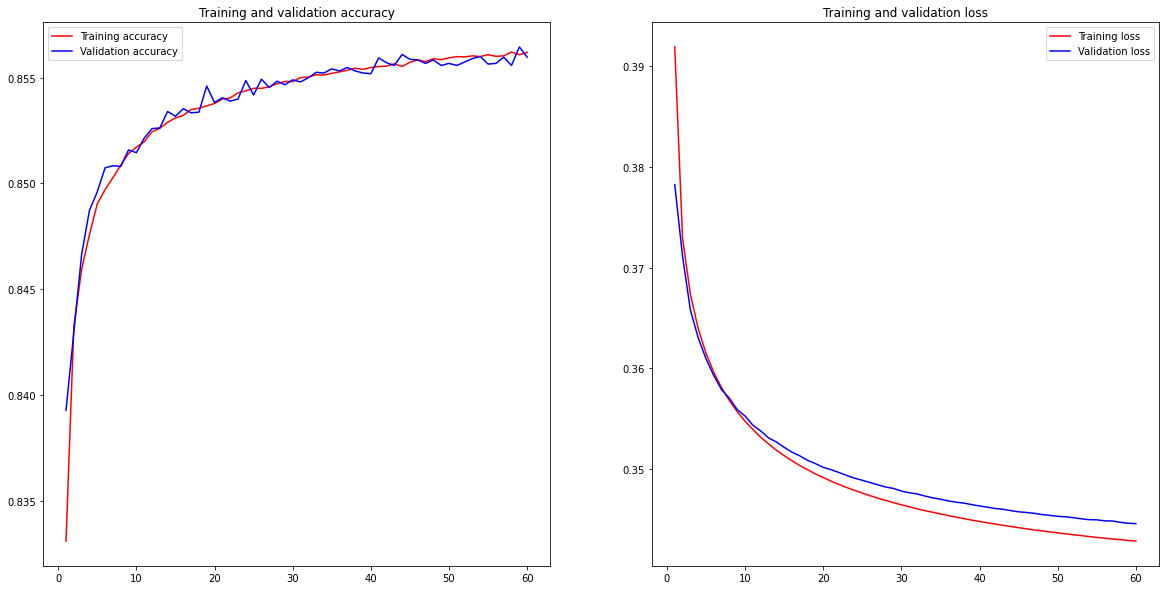

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()
ax2.plot(epochs, loss, 'r', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

In [19]:
y_pred = nn_model.predict(X_test_reduced)
y_pred = (y_pred > 0.5).astype(int)
print(f'Test accuracy: {metrics.accuracy_score(y_test, y_pred)}')

Test accuracy: 0.855797675096871
